In [1]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools

%load_ext autoreload
%autoreload 2

In [2]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [3]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [4]:
t_es = np.logspace(-3, 1, 20) #hours

In [49]:
m = 1e-8
s.add_pbh(m)
diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)

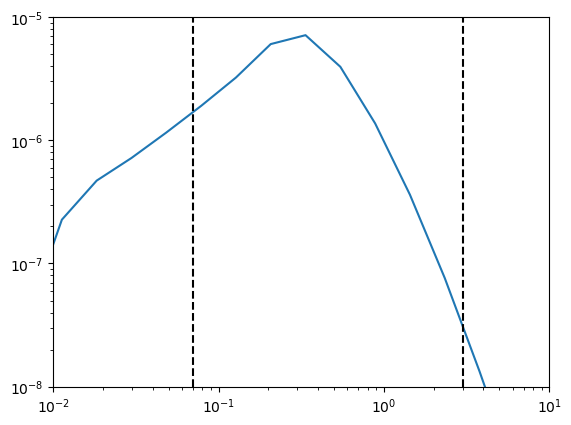

In [50]:
plt.loglog(t_es, diff_rates)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8,1e-5)
plt.show()

In [51]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [5]:
ti = 0.07
tf = 3
# dnds = quad(diff_rate_interp, ti, tf)[0]

In [53]:
s.n_sources*efficiency*dnds

216.14153800078398

In [7]:
def get_n_events(m, finite=False):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        # results = list(p.imap(f, m_pbhs))
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [9]:
m_pbhs = np.logspace(-16, -4, 25) #solar masses
fdms = get_constraint_fdm_parallel(m_pbhs, finite=False)

100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


In [10]:
fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)

100%|██████████| 25/25 [01:28<00:00,  3.52s/it]


In [11]:
# Define conversion factor
sol_to_gram = 1.989e33
m_grams = [x*sol_to_gram for x in m_pbhs]

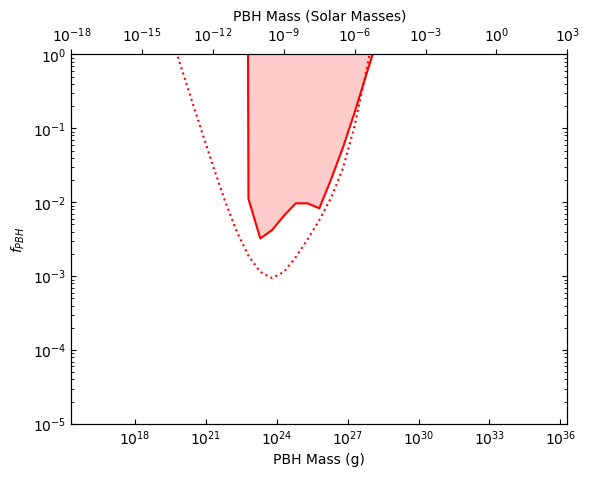

In [13]:
# Define conversion factor
sol_to_gram = 1.989e33

fig, ax2 = plt.subplots()

# Plot on first x-axis
ax2.plot(m_grams, fdms, 'r', ls=':')
ax2.plot(m_grams, fdm_finite, 'r', ls='-')
ax2.fill_betweenx(fdm_finite, m_grams, color='r', alpha=0.2)  # shade the area above the curve
# ax2.fill_betweenx(fdms, [x*sol_to_gram for x in m_pbhs], color='r', alpha=0.2)  # shade the area above the curve

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('PBH Mass (g)')
ax2.set_ylabel(r'$f_{PBH}$')
ax2.set_ylim(1e-5, 1e0)
ax2.set_xlim([x*sol_to_gram for x in [1e-18, 1e3]])

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax1 = ax2.twiny()  # create a second x-axis

# Set the limits of the second x-axis
ax1.set_xlim(1e-18, 1e3)
ax1.set_xscale('log')
ax1.set_xlabel('PBH Mass (Solar Masses)')

plt.show()